# Probabilistic Machine Learning
<div style="text-align: right"> University of Tübingen, Summer Term 2023  &copy; 2023 P. Hennig </div>

## Exercise Sheet No. 10 — Overcoming DL Overconfidence via Laplace Approximations

---

Submission by: Batuhan, Oezcoemlekci(Matrikelnummer: 6300476) and Aakarsh, Nair( Matrikelnummer: 6546577)

<hr style="margin: 50px">



<br style="margin: 20px">

<!-- neutral: #ededf2 -->
<!-- note: #e4eefb -->
<!-- warning: #ffe0e0 -->
<!-- tip: #e4fae4 -->
<div style="padding: 10px; border-radius: 10px; border-style: solid; border-width: thin; background-color: #e4eefb; margin: auto; width: 75%; font-size: 20px; text-align: center">
The lecture presented a fundamental connection between Deep Learning (DL) and Gaussian Processes (GPs), articulated via Laplace Approximations (LAs). And in the last tutorial, we successfully trained a DL setup on binary MNIST, exploring the least and most confusing examples as predicted by the trained model.
    
<br>    
In this tutorial, we will extend last week's DL setup using LAs, upgrading the concept of least and most confusing examples by incorporating uncertainty from the LA posterior. In the process we will also learn how to compute Hessians, and other tailored gradient quantities with <code>jax</code>.
    
<br>    
<b>See the <code>Tasks and Evaluation Rules</code> section for more details.</b>
</div>

<br style="margin: 20px">


# Background:

<br>
<div style="padding: 10px; border-radius: 10px; border-style: solid; border-width: thin; background-color: #ededf2; margin: auto; width: 75%; text-align: center">
This cell revisits concepts already presented in the lecture as well as in Agustinus Kristiadi's <a href="https://agustinus.kristia.de/techblog/2021/10/27/laplace/">blog</a> and <a href="https://arxiv.org/abs/2002.10118">paper</a>, and is included here for reference (free to skip to the task descriptions below).
</div>

Recall the following components involved in a typical DL setup, like the ones used in last tutorial:

* **Dataset**: $\mathcal{D} = [(x_i, y_i)]_{i=1}^N$
* **Model**: $\hat{y}_i = f(x_i, \theta)$, with parameters $\theta \in \mathbb{R}^D$
* **Objective**: $\mathcal{L}(\theta) := \frac{1}{N} \sum_{i=1}^N \Big\{ \ell \big(y_i, f(x_i, \theta) \big) \Big\} + \rho(\theta)$

We will also make use of the basic building blocks from a Bayesian perspective:

1. **Bayes' Theorem**: $p(\theta | \mathcal{D}) = p(\mathcal{D} | \theta) \cdot p(\theta) \cdot \frac{1}{p(\mathcal{D})}$
2. The **posterior** $p(\theta | \mathcal{D})$
3. An **[i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables) likelihood** in the form $p(\mathcal{D} | \theta) = \prod_{i=1}^N p \big(y_i ~|~ f(x_i, \theta) \big)$
4. A **prior** $p(\theta)$
5. The **evidence** or **marginal** $p(\mathcal{D}) = \int_{\theta \in \Theta} p(\mathcal{D} | \theta) p(\theta) d\theta$, typically intractable for DL due to large  $\dim(\theta)$ and/or large $N$.
6. The **predictive** $p(y | x', \mathcal{D}) = \int_{\theta \in \Theta} p(y | \theta, x) p(\theta | \mathcal{D}) d \theta$, which integrates knowledge of the posterior during inference of some input $x'$.

In this tutorial, we seek to compute the predictive distribution, which also requires the posterior. But this is not possible if the evidence is intractable. The idea of LA is to approximate the posterior in a computationally efficient way, by first linking the actual posterior to the DL loss $\mathcal{L}$, and then showing that a gradient-based approximation of $\mathcal{L}$ leads to a closed-form Gaussian that approximates the posterior. As a consequence, the predictive distribution becomes a Gaussian Process. Let's break down the steps:

---

**First**, we observe that there is a way to obtain useful information about the posterior without requiring the evidence at all. The maximum-a-posteriori (MAP) $\theta_*$ can be satisfied by the DL *objective* under reasonable assumptions:

\begin{align}
\theta_* := ~&\arg \max_\theta ~\log \big( \underbrace{p(\mathcal{D} | \theta) \cdot p(\theta)}_{\propto p(\theta | \mathcal{D})} \big)\\
              = ~&\arg \max_\theta ~\sum_{i=1}^N \Big\{ \log p \big( y_i ~|~ f(x_i, \theta) \big) \Big\}~+~ \log p(\theta)\\
              = ~&\arg \max_\theta ~\mathcal{L}(\theta)\\
\end{align}

The assumptions for the last equality are:

* The log-likelihood $\log p \big( y_i ~|~ f(x_i, \theta) \big)$ can be expressed as a differentiable loss function $\frac{1}{N} \ell \big(y_i, f(x_i, \theta) \big)$. This is the case for popular objectives like binary cross-entropy.
* The log-prior $\log p(\theta)$ can be expressed as a Tikhonov regularizer in the form $\lambda \lVert \theta \rVert$. This is also the case for popular regularizers (e.g. a Gaussian $p(\theta) \sim \mathcal{N}(\theta | 0, \lambda)$, [corresponds to $\ell_2$ regularization](https://stats.stackexchange.com/a/163450) with $\lambda \lVert \theta \rVert_2^2$).


So the first step is to optimize the DL setup exactly as we did last week, to obtain an estimate $\theta_*$ (our trained model). This is tractable, and it may perform well on $\mathcal{D}$ and related data, but it is still a single point in the (typically huge) posterior $p(\theta | \mathcal{D})$: it doesn't provide uncertainty quantification, and often leads to issues like [pathological overconfidence](https://arxiv.org/abs/1812.05720), so we would still like to pursue our original goal of a posterior distribution.

---

 For our **second step**, we observe that the established equality $\log p(\mathcal{D} | \theta) \cdot p(\theta) = \mathcal{L}(\theta)$ can be further approximated through a second-order Taylor expansion (a.k.a.*linearization*) of $\mathcal{L}$ in the vicinity of $\theta_*$:

\begin{align}
\mathcal{\hat{L}}(\theta) := ~&\mathcal{L}(\theta_*) + \underbrace{\big( \nabla_{\theta}\mathcal{L}(\theta_*) \big)^\top (\theta - \theta_*) }_{= 0} + \frac{1}{2} (\theta - \theta_*)^\top \Psi (\theta - \theta_*)
\end{align}

Where $\Psi$ is the *Hessian* matrix of second-order derivatives at $\theta_*$ with entries $\Psi_{i,j} :=  \frac{\partial^2}{\partial \theta_i \partial \theta_j} \mathcal{L}(\theta_*)$. Note that the gradient at the MAP is zero so the second term can be ignored and $\Psi$ is [PSD](https://en.wikipedia.org/wiki/Definite_matrix) (see theory exercises). In step 1 we linked our Bayesian problem to optimization, and now we were able to further establish a powerful connection with the DL gradients!

---

The **third step** finalizes the *Laplace Approximation* of the posterior by expressing the approximate posterior as a Gaussian distribution in closed form. For that, we first recap the steps done so far and observe that the approximate posterior is proportional to a quadratic exponential function:

\begin{align}
\log \big( p(\mathcal{D} | \theta) \cdot p(\theta) \big) \approx \mathcal{\hat{L}}(\theta)  ~~~\Rightarrow~~~ p(\theta | \mathcal{D}) \propto p(\mathcal{D} | \theta) \cdot p(\theta) \approx \exp \mathcal{\hat{L}}(\theta) =  \underbrace{ \exp \{ \mathcal{L}(\theta_*) \}}_{\text{constant}}\cdot \underbrace{\exp \{ \frac{1}{2} (\theta - \theta_*)^\top \Psi (\theta - \theta_*) \}}_{\text{function of } \theta}
\end{align}

We can calculate the integral of the rightmost expression in closed form thanks to the [Gaussian integral](https://en.wikipedia.org/wiki/Gaussian_integral):

\begin{align}
\int_{\theta \in \Theta} \Big\{ \exp \{ \mathcal{L}(\theta_*) \} \cdot \exp \{ \frac{1}{2} (\theta - \theta_*)^\top \Psi (\theta - \theta_*) \} d \theta \Big\} =&~ \exp \{ \mathcal{L}(\theta_*) \} \cdot \sqrt{(2 \pi)^D ~ \det(-\Psi^{-1})}
\end{align}

Note how this is an approximation of the previously intractable evidence!

\begin{align}
p(\mathcal{D}) = \int_{\theta \in \Theta} p(\mathcal{D} | \theta) p(\theta) d \theta ~~\approx~~ \exp \{ \mathcal{L}(\theta_*) \} \cdot \sqrt{(2 \pi)^D ~ \det(-\Psi^{-1})}
\end{align}

So now we can apply full Bayes to obtain the LA of the posterior:

\begin{align}
p(\theta | \mathcal{D}) = \frac{p(\mathcal{D} | \theta) \cdot p(\theta)}{p(\mathcal{D})} \approx \frac{\exp \{ \mathcal{L}(\theta_*) \} \cdot \exp \{ \frac{1}{2} (\theta - \theta_*)^\top \Psi (\theta - \theta_*) \}}{\exp \{ \mathcal{L}(\theta_*) \} \cdot \sqrt{(2 \pi)^D ~ \det(-\Psi^{-1})}} &= \frac{1}{\sqrt{(2 \pi)^D ~ \det(-\Psi^{-1})}} \cdot \exp \{ - \frac{1}{2} (\theta - \theta_*)^\top (- \Psi) (\theta - \theta_*) \}\\
&= \mathcal{N}(\theta ~|~ \theta_*,  -\Psi^{-1})
\end{align}

Yielding the closed-form expression for the LA posterior.


---

For this tutorial, we add a **fourth step**: we want to incorporate the LA posterior during inference of any arbitrary input $x'$ (not necessarily from $\mathcal{D}$).  Note that our LA posterior $p(\theta | \mathcal{D})$ is a distribution on the *parameters*, how are we supposed to use it for *predictions*? This is the role of the [*predictive distribution*](https://en.wikipedia.org/wiki/Posterior_predictive_distribution) $p(y | x', \mathcal{D})$, generally derived as follows:

\begin{align}
p(y | x', \mathcal{D}) = \int_{\theta \in \Theta} p(y, \theta | x', \mathcal{D}) d \theta = \int_{\theta \in \Theta} \frac{p(y, \theta, x', \mathcal{D})}{p(x', \mathcal{D})} d \theta = \int_{\theta \in \Theta} \frac{p(y | \theta, x', \mathcal{D}) p(\theta | x', \mathcal{D}) p(x', \mathcal{D})}{p(x', \mathcal{D})} d \theta = \int_{\theta \in \Theta} p(y | \theta, x') p(\theta | \mathcal{D}) d \theta
\end{align}

Where the last equality is based on two conditional independence assumptions (recall: $p(a, b | c) = p(a, c) p(b, c)  \iff p(a | b, c) = p(a | c)$ and $p(b | a, c) = p(b | c)$):

* $p(y | \theta, x', \mathcal{D}) = p(y | \theta, x')$, i.e. $y \perp\!\!\!\perp \mathcal{D} | (\theta, x')$.
* $p(\theta | x', \mathcal{D}) = p(\theta | \mathcal{D})$, i.e. $\theta \perp\!\!\!\perp x' | \mathcal{D}$.

In our LA setup, $p(\theta | \mathcal{D})$ is Gaussian, and $p(y | \theta, x') = \sigma(f(x', \theta))$ is our DL model. While the predictive distribution has no analytic solution in general, we can use this information to approximate it as follows:

\begin{align}
p(y = 1 | x', \mathcal{D}) \approx \sigma \Big( \frac{f(x', \theta_*)}{\sqrt{1 + \frac{\pi}{8}  J(x')^\top (-\Psi^{-1}) J(x')}} \Big)  =: \sigma(z(x'))
\end{align}

A derivation can be found in [eq. 5 of this paper](https://arxiv.org/abs/2002.10118). It involves a further approximation for the predictive, as well as linearizing $f(x', \theta) \approx f(x', \theta_*) + J(x') (\theta - \theta_*)$ such that $J(x')_{ij} := \frac{\partial}{\partial \theta_j} f(x', \theta_*)_i$ is the Jacobian matrix of $f$ with respect to $\theta_*$.



In a regular DL setup for binary classification, we typically assess the *confidence* of a given prediction by computing $\sigma(|f(x', \theta_*)|)$ (so-called MAP confidence). **Here, we assess the confidence by computing $\sigma(|z(x')|)$** (we call this the LA-predictive confidence). Observe how the main difference is articulated through the $J(x')^\top (-\Psi^{-1}) J(x')$ quadratic form, which encodes learned information purely via the gradients and, at the $\theta_*$ MAP, is a PSD matrix corresponding to the *Laplace Tangent Kernel (LTK)*. As a final motivation, we highlight a few interesting properties of this predictive approximation:

1. It preserves the decision boundary induced by the MAP estimate (i.e. it does not "hurt" the DL classification setup in any way).
2. It helps fixing overconfidence (see [paper]((https://arxiv.org/abs/2002.10118)) for extensive work on this).
3. It can be formulated as a Gaussian Process with the LTK (see lecture notes). 



---

One **Final remark**: Since we are concerned with tractability of computations, we observe that computing $\Psi$ is generally also unfeasible in terms of memory and runtime (let alone $\Psi^{-1}$!), even for tiny neural networks. This week's theory exercises explore this aspect of LA in more depth. In this tutorial, we will circumvent this issue by performing *last-layer LAs*, where the main difference is that we compute the derivatives with respect to the last-layer weights only. The full procedure to perform LA inference is nicely outlined in the [paper, Algorithm 1](https://arxiv.org/abs/2002.10118). 

<hr style="margin: 50px">

# Tasks and Evaluation Rules:

In this tutorial, we provide full code to train last week's DL setup on binary MNIST, you just have to run the existing cells. The tasks begin once the model has been trained and involve implementing a LA extension as well as using it to analyze uncertainties. Specifically, you will:

1. Define a `jax` function to compute the last-layer Hessian.
2. Define a `jax` function to compute the last-layer Jacobian.
3. Define a function to compute the predictive confidence over the test set.


<br style="margin: 10px">
<div style="border-radius: 10px; background-color: #ffe0e0; width: 85%;  text-align: left; margin: auto;">
  <div style="background: rgba(0, 0, 0, 0.05); border-style: solid; border-width: thin; border-radius: 10px; filter: brightness(0.9); padding: 10px; "><p style=""><b>TUTORIAL EVALUATION RULES:</b></p>
  </div>
<div style="padding: 10px">
<ul>
<li>These tasks can be fulfilled with the already imported libraries, and no further libraries should be needed (feel free to import Python standard libraries).</li>
<li>The cells below provide some scaffolding code that can be optionally used as a starting point (in which case the docstrings can be used as guidance, and the missing bits are signaled via <code>NotImplemented</code>, <code>NotImplementedError</code> and <code>"TODO"</code>.</li>
<li>The <code>Expected Result</code> cells can be used as a guidance and to showcase correct functionality. In principle, they don't need to be modified, but it is allowed.</li>
<li>Code can be partially borrowed from external sources (to the extent permitted by University guidelines) but it must be documented via docstrings and/or comments to show sufficient understanding of its interface and functionality (no blind copypaste allowed).</li>
</ul>
</div>    
</div>

<hr style="margin: 50px">

# Imports and Helpers

In [1]:
# standard imports
import urllib.request  # to download MNIST
import gzip            # to download MNIST
from time import time

# Numerics
import jax
import jaxlib
import jax.numpy as jnp
from jax.example_libraries import optimizers as jopt
import numpy as np
jax.config.update("jax_enable_x64", True)  # use double-precision numbers
jax.config.update("jax_platform_name", "cpu")  # we don't need GPU here

# Plotting
from matplotlib import pyplot as plt
from tueplots import bundles

plt.rcParams.update({"figure.dpi": 200})
plt.rcParams.update(bundles.beamer_moml())


import warnings
import logging

logging.getLogger('matplotlib').setLevel(level=logging.CRITICAL)
warnings.filterwarnings( "ignore", module = "matplotlib\..*")
                        
%config InlineBackend.figure_formats = ["svg"]
%matplotlib inline

In [2]:
def inspect_batch(x_data, y_data, width=1.8, cmap="cividis", title=None):
    """
    Plot all given MNIST images with their corresponding labels.
    :param x_data: Numpy array of images with shape ``(b, h, w)``.
    :param y_data: Numpy array of labels with shape ``(b,)``
    :returns: Figure and axes.
    """
    num_axes = len(x_data)
    assert len(y_data) == num_axes, "Inconsistent inputs!"
    plt.rcParams.update(bundles.beamer_moml(rel_width=width))
    fig, axes = plt.subplots(ncols=num_axes)
    for i, ax in enumerate(axes):
        ax.imshow(x_data[i], cmap=cmap)
        ax.set_title(str(y_data[i]))
        ax.set_xticks([])
        ax.set_yticks([])
    if title is not None:
        fig.suptitle(title)
    return fig, axes

<hr style="margin: 50px">

# Training and Test Data

Since we aim to do binary classification and explore the model confidence, we will focus on two rather similar MNIST handwritten digits: 1 and 7. The following cell contains a convenience class that will allows us to download MNIST, store it persistently, and extract a binarized and standardized version.

In [3]:
class MNIST:
    """
    Static class to download MNIST into numpy arrays and extract a two-digit
    subset.
    """
    BASE_URL = "http://yann.lecun.com/exdb/mnist/"
    X_TRAIN_URL = "train-images-idx3-ubyte.gz"
    Y_TRAIN_URL = "train-labels-idx1-ubyte.gz"
    X_TEST_URL = "t10k-images-idx3-ubyte.gz"
    Y_TEST_URL = "t10k-labels-idx1-ubyte.gz"
    X_SHAPE = (28, 28)

    @classmethod
    def download(cls):
        """
        The MNIST dataset used in this notebook has been downloaded with this
        function. Returns a dict with the following ``np.uint8`` arrays:
        * x_train: (60000, 28, 28), y_train: (60000,)
        * x_test:  (10000, 28, 28), y_test:  (10000,)
        """
        x_train = urllib.request.urlopen(cls.BASE_URL + cls.X_TRAIN_URL).read()
        x_train = gzip.decompress(x_train)
        x_train = np.frombuffer(x_train, np.uint8, offset=16).reshape(
            -1, *cls.X_SHAPE)
        #
        y_train = urllib.request.urlopen(cls.BASE_URL + cls.Y_TRAIN_URL).read()
        y_train = gzip.decompress(y_train)
        y_train = np.frombuffer(y_train, np.uint8, offset=8)
        #
        x_test = urllib.request.urlopen(cls.BASE_URL + cls.X_TEST_URL).read()
        x_test = gzip.decompress(x_test)
        x_test = np.frombuffer(x_test, np.uint8, offset=16).reshape(
            -1, *cls.X_SHAPE)
        #
        y_test = urllib.request.urlopen(cls.BASE_URL + cls.Y_TEST_URL).read()
        y_test = gzip.decompress(y_test)
        y_test = np.frombuffer(y_test, np.uint8, offset=8)
        #
        return {"x_train": x_train, "y_train": y_train,
                "x_test": x_test, "y_test": y_test}

    @classmethod
    def extract_bmnist(cls, mnist, pos_digit=1, neg_digit=7,
                       standardize_imgs=True, dtype=np.float64):
        """
        :param mnist: The output of ``download``
        :param standardize_imgs: If true, returned images will have zero mean
          and unit variance.
        :param dtype: Ideally a large-resolution float.
        :returns: A dictionary that is a subset of the given ``mnist``, but
          only with ``pos_digit`` labeled as 1, and ``neg_digit`` labeled as 0.
        """
        # gather only desired digits, and label them +1, -1
        train_mask = (mnist["y_train"] == pos_digit) | (mnist["y_train"] ==
                                                        neg_digit)
        test_mask = (mnist["y_test"] == pos_digit) | (mnist["y_test"] ==
                                                      neg_digit)
        bmnist = {
            "x_train": mnist["x_train"][train_mask].astype(dtype),
            "y_train": ((mnist["y_train"][train_mask] == POS_DIGIT)).astype(dtype),
            "x_test": mnist["x_test"][test_mask].astype(dtype),
            "y_test": (mnist["y_test"][test_mask] == POS_DIGIT).astype(dtype)}
        # sanity check
        len_x_train, len_y_train = len(bmnist["x_train"]), len(bmnist["y_train"])
        len_x_test, len_y_test = len(bmnist["x_test"]), len(bmnist["y_test"])
        assert len_x_train == len_y_train, "Inconsistent training data in mnist?"
        assert len_x_test == len_y_test, "Inconsistent test data in mnist?"
        # optionally standardize images
        if standardize_imgs:
            bmnist["x_train"] -= bmnist["x_train"].reshape(len_x_train, -1).mean(axis=1)[:, None, None]
            bmnist["x_train"] /= bmnist["x_train"].reshape(len_x_train, -1).std(axis=1)[:, None, None]
            bmnist["x_test"] -= bmnist["x_test"].reshape(len_x_test, -1).mean(axis=1)[:, None, None]
            bmnist["x_test"] /= bmnist["x_test"].reshape(len_x_test, -1).std(axis=1)[:, None, None]
        #
        return bmnist


# Attempt to recover preexisting mnist. If not preexisting, download anew and save
%store -r mnist
try:
    mnist
    print("Fetched MNIST from storage!")
except NameError:
    print("Downloading MNIST...")
    mnist = MNIST.download()
    %store mnist

Fetched MNIST from storage!


Inspect some samples from binary MNIST:

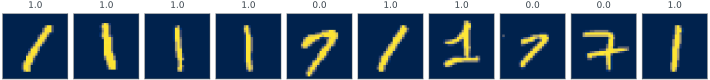

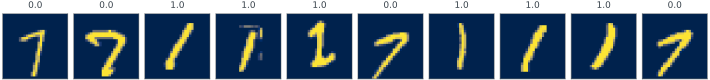

In [4]:
POS_DIGIT, NEG_DIGIT = 1, 7  # feel free to play around with these, but stick to (1, 7) for the submission
DTYPE = np.float64
bmnist = MNIST.extract_bmnist(mnist, POS_DIGIT, NEG_DIGIT, True, DTYPE)

inspect_samples = list(range(0, 10))
inspect_batch(bmnist["x_train"][inspect_samples], 
              bmnist["y_train"][inspect_samples])

inspect_samples = list(range(10, 20))
inspect_batch(bmnist["x_train"][inspect_samples], 
              bmnist["y_train"][inspect_samples]);

<hr style="margin: 50px">

# DL Hyperparameters

In [5]:
# model architecture and initialization
LAYER_SIZES = (784, 256, 64, 1)
INIT_STDDEV = 0.1
CLASSIFICATION_THRESHOLD = 0.5

# optimizer/objective
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-12

# training protocol
NUM_BATCHES = 5000
BATCH_SIZE = 25
RANDOM_SEED = 12345

<hr style="margin: 50px">

# Dataloaders

In [6]:
def train_dataloader(bmnist, batch_size=50, rng=jax.random.PRNGKey(12345)):
    """
    Given a binary MNIST dataset, this generator runs infinitely, returning
    randomized batches from the training split.
    
    :param bmnist: Dictionary as returned by ``MNIST.extract_bmnist``
    :param rng: If a ``jax```random key is given, use it to shuffle
      all entries.
    :yields: An input-output pair of numpy arrays ``(x, y)``, where
      the first dimension of the arrays equals ``batch_size``,
      except for the last batch that may be smaller.
    """
    len_train = len(bmnist["x_train"])
    while True:
        rng = jax.random.split(rng)[1]
        perm = jax.random.permutation(rng, len_train)
        for i in range(0, len_train, batch_size):
            x = bmnist["x_train"][perm[i : (i + batch_size)], ...]
            y = bmnist["y_train"][perm[i : (i + batch_size)], ...]
            yield (x, y)


def test_dataloader(bmnist, batch_size=50):
    """
    Given a binary MNIST dataset, this generator runs once over its
    test split, in batched manner.
    
    :param bmnist: Dictionary as returned by ``MNIST.extract_bmnist``
    :yields: An input-output pair of numpy arrays ``(x, y)``, where
      the first dimension of the arrays equals ``batch_size``,
      except for the last batch that may be smaller.
    """
    assert batch_size > 0, "batch_size <= 0 not supported"
    for i in range(0, len(bmnist["x_test"]), batch_size):
        x = bmnist["x_test"][i : (i + batch_size), ...]
        y = bmnist["y_test"][i : (i + batch_size), ...]
        yield (x, y)

<hr style="margin: 50px">

# DL Model and Initialization

In [7]:
def mlp(params, inputs, nonlinearity=jax.nn.relu):
    """
    Computes the forward pass of an MLP, defined using JAX components. Note that
    it returns the *logits*. To map logits into predicted scores, a sigmoid
    function can be applied.
    
    :param params: List of pairs in the form ``[(w1, b1), (w2, b2), ...]`` where
      ``w_i, b_i`` are the weights and biases for layer ``i``, such that a layer
      computes ``outputs = nonlinearity((w_i @ inputs) + b_i)``.
    :param inputs: Batch of flattened input images with shape ``(batch, in_shape)``
    :returns: A vector of shape ``(batch,)``, containing one logit per input that
      should predict the corresponding binary class.
    """
    result = inputs
    for w_i, b_i in params[:-1]:
        result = nonlinearity(jnp.dot(result, w_i) + b_i)
    #
    final_w, final_b = params[-1]
    logits = jnp.dot(result, final_w) + final_b
    return logits[..., 0]


def create_mlp_params(layer_sizes, stddev=0.1, rng=jax.random.PRNGKey(12345)):
    """
    Creates MLP parameters of given sizes and initializes them with Gaussian
    noise of zero mean and given standard deviation.
    :param layer_sizes: List of integers in the form ``[d1, d2, ...]``,
      where each MLP layer maps from ``d_i`` dimensions to ``d_{i+1}``.
    :param stddev: Standard deviation of the initial Gaussian noise.
    :param rng: ``jax.random.PRNGKey`` to draw noise from.
    """
    params = []
    for m, n in zip(layer_sizes[:-1], layer_sizes[1:]):
        rng, rng_b = jax.random.split(rng)
        w = jax.random.normal(rng, (m, n)) * stddev
        b = jax.random.normal(rng_b, (n,)) * stddev
        params.append((w, b))
    return params


def test_predictions(params, bmnist, batch_size=50, threshold=0.5):
    """
    Helper function to run ``sigmoid(model)`` over the whole test subset
    and compute the accuracy.
    
    :param threshold: Any sigmoid outputs above this number will be consider
      positive (i.e. a value of 1), otherwise negative (i.e. a value of 0).
    :param bmnist: See ``test_dataloader``.
    :param batch_size: See ``test_dataloader``.
    :returns: The triple ``(accuracy, logits, targets)``, where 
      ``accuracy`` is the ratio of correctly classified samples, ``logits``
      are the predicted logits following the order provided by
      ``test_dataloader``, and ``targets`` are the corresponding ground
      truth annotations.
    """
    all_logits = []
    targets = []
    for x_batch, y_batch in test_dataloader(bmnist, batch_size):
        logits = mlp(params, x_batch.reshape(len(x_batch), -1))
        all_logits.extend(list(logits))
        targets.extend(list(y_batch))
    #
    predictions = jax.nn.sigmoid(np.array(all_logits)) > threshold
    targets = jnp.array(targets)
    accuracy = (predictions == targets).sum() / len(predictions)
    return accuracy, all_logits, targets

<hr style="margin: 50px">

# DL Objective and Evaluation Metrics

We define the DL objective in the form:

$\mathcal{L}(\theta) := \frac{1}{B} \sum_{i \in \{\mathcal{B}_1, \dots, \mathcal{B}_B\}} \big\{ \ell(y_i, f(x_i, \theta)) \big\} + \rho(\theta)$

Where $\ell$ is the binary cross-entropy, and $\rho$ is the L2 regularizer on all MLP parameters.

In [8]:
def loss_fn(params, inputs, targets, l2_reg=0.0):
    """
    :param params: Network parameters. See ``mlp`` docstring.
    :param inputs: Batch of network inputs. See ``mlp`` docstring.
    :param targets: Batch of ground truth annotations corresponding to ``inputs``,
      as provided by the dataloader.
    :param l2_reg: Strength of the L2 regularization term, such that
      ``result = cross_entropy + (0.5 * l2_reg * l2norm(params)**2)``.
    :returns: A single scalar representing the empirical risk plus the L2 
      regularizer over the given batch, with respect to the given parameters.
    """
    # ERM via cross-entropy
    preds = mlp(params, inputs) # this returns log probabilities
    result = jnp.logaddexp(0, -preds * (2 * targets - 1)).mean()    
    # L2 regularization
    reg = 0.5 * l2_reg * sum(jnp.sum(w ** 2) + jnp.sum(b ** 2) for w, b in params)
    result = result + reg
    #
    return result

<hr style="margin: 50px">

# DL Training Loop

The cell below trains our MLP on binary MNIST to obtain an estimate of $\theta_*$ (here called `MAP_PARAMS`). This will allow us to start our LA journey. After a few seconds, the model should converge to less than 0.1 loss and over 90% accuracy.

[step 0000200] Loss=0.082918, Test accuracy=0.966251
[step 0000400] Loss=0.059265, Test accuracy=0.976422
[step 0000600] Loss=0.039452, Test accuracy=0.979196
[step 0000800] Loss=0.024959, Test accuracy=0.980583
[step 0001000] Loss=0.026530, Test accuracy=0.981969
[step 0001200] Loss=0.241486, Test accuracy=0.984281
[step 0001400] Loss=0.015807, Test accuracy=0.984281
[step 0001600] Loss=0.018574, Test accuracy=0.984281
[step 0001800] Loss=0.030603, Test accuracy=0.986130
[step 0002000] Loss=0.076650, Test accuracy=0.986130
[step 0002200] Loss=0.004356, Test accuracy=0.986593
[step 0002400] Loss=0.008845, Test accuracy=0.987055
[step 0002600] Loss=0.023894, Test accuracy=0.987055
[step 0002800] Loss=0.006475, Test accuracy=0.987980
[step 0003000] Loss=0.013887, Test accuracy=0.987517
[step 0003200] Loss=0.029894, Test accuracy=0.987980
[step 0003400] Loss=0.006789, Test accuracy=0.988442
[step 0003600] Loss=0.007169, Test accuracy=0.988904
[step 0003800] Loss=0.005232, Test accuracy=0.

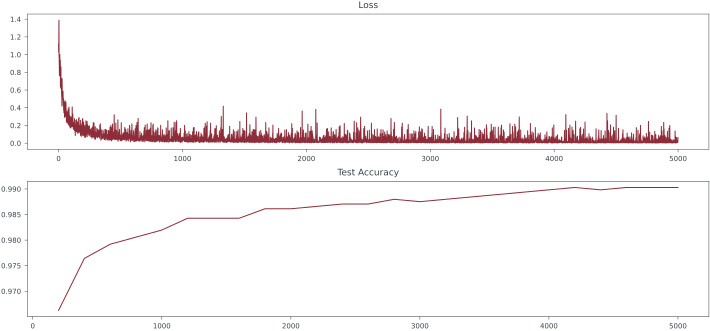

In [9]:
# 1. Dataloaders
train_dl = train_dataloader(bmnist, BATCH_SIZE, rng=jax.random.PRNGKey(RANDOM_SEED))
test_dl = test_dataloader(bmnist, BATCH_SIZE)

# 2. Model params
mlp_params = create_mlp_params(LAYER_SIZES, INIT_STDDEV, 
                               jax.random.PRNGKey(RANDOM_SEED))

# 3. Optimizer and JIT update step
opt_init, opt_update, get_params = jopt.sgd(LEARNING_RATE)
opt_state = opt_init(mlp_params)

@jax.jit
def update(step, opt_state, inputs, targets, l2_reg=0.0):
    """
    In order to speed up computations (not really necessary for small
    examples like this one, but crucial for larger DL setups), we 
    "bundle" the forwardprop, backprop and update steps into a single
    JIT-able function.
    """
    value, grads = jax.value_and_grad(loss_fn)(get_params(opt_state), 
                                               inputs, targets, l2_reg)
    opt_state = opt_update(step, grads, opt_state)
    return value, opt_state


# Training loop
losses, test_accs = [], []  # we will gather losses and accuracies
t0 = time()
#
for batch_t, (x_batch, y_batch) in enumerate(train_dl, 1):
    if batch_t > NUM_BATCHES:
        break
    #
    x_batch = x_batch.reshape(len(x_batch), -1)
    loss, opt_state = update(batch_t, opt_state, x_batch, y_batch, WEIGHT_DECAY)
    losses.append(loss)
    if batch_t % 200 == 0:
        test_acc, _, _ = test_predictions(get_params(opt_state), bmnist,
                                       BATCH_SIZE, CLASSIFICATION_THRESHOLD)
        print(f"[step {batch_t:07d}] Loss={loss:5f}, Test accuracy={test_acc:2f}")
        test_accs.append((batch_t, test_acc))
#
print("Elapsed seconds:", time() - t0)

# Once trained, gather the MAP params to use later!
MAP_PARAMS = get_params(opt_state)


plt.rcParams.update(bundles.beamer_moml(rel_width=1.8, rel_height=1.5))
fig, (ax_loss, ax_acc) = plt.subplots(nrows=2)
#
ax_loss.plot(range(NUM_BATCHES), losses)
ax_loss.set_title("Loss")
#
ax_acc.plot(*zip(*test_accs))
_ = ax_acc.set_title("Test Accuracy")

<hr style="margin: 50px">

# Laplace Approximation

Here is where this week's work starts. Note that, thanks to the elegant closed-form of the LA posterior $p(\theta | \mathcal{D}) \approx \mathcal{N}(\theta ~|~ \theta_*,  -\Psi^{-1})$, all we need to do on top of DL training is computing and inverting the Hessian. But, as we mentioned, computing the full Hessian, even for our small MLP, is not feasible. Our first task is to define a function that computes the Hessian only for the last layer of our MLP. Feel free to use or ignore the provided helper, `LossFnWrapper`.

<br style="margin: 10px">
<div style="border-radius: 10px; background-color: #e4eefb; width: 85%;  text-align: center; margin: auto;">
<div style="background: rgba(0, 0, 0, 0.05); border-style: solid; border-width: thin; border-radius: 10px; filter: brightness(0.9); padding: 10px; "><p style=""><b><code>jax</code> tip:</b></p>
</div>
<div style="padding: 10px">
Recall that <code>jax</code> follows a functional programming paradigm, and that this often results in verbose interfaces (i.e. large lists of inputs/outputs). One popular way of circumventing this is via <a href="https://en.wikipedia.org/wiki/Currying"><i>currying</i></a>, which consists in partially evaluating a function with a subset of more "stable" arguments, removing them from the parameter list upon further calls; i.e.:
    instead of computing <code>result1 = f(a, b, c, d, e1, f1)</code> and then <code>result2 = f(a, b, c, d, e2, f2)</code>, we first define <code>f_abcd = partial_fn(f(a, b, c, d))</code> and then we compute <code>result1 = f_abcd(e1, f1)</code> and <code>result2 = f_abcd(e2, f2)</code>.
<br>
<br>
A typical example would be to define a normal distribution <code>normal(x, mean, covmat)</code>  first by its parameters <code>mean, covmat</code>, and then just call it for each different <code>x</code>. Apart from reducing verbosity, currying can also enhance performance by avoiding to run twice any computations that only depend on the "curried-out" parameters (imagine that we would need to invert <code>covmat</code>: we do it only once when the partial is defined, instead of once per function call). In Python, the built-in <a href="https://docs.python.org/3/library/functools.html"><code>functools</code></a> library provides a lot of support for these as well as many other functional programming patterns.
<br>
<br>
The <code>jax</code> library makes extensive use of currying, see e.g. the documentation for <a href="https://jax.readthedocs.io/en/latest/_autosummary/jax.hessian.html#jax.hessian"><code>jax.hessian</code></a>. One relevant example for us is the <code>argnums</code> curried parameter: the derivative is always computed with respect to a subset of the parameters, and <code>argnums</code> allows us to specify which subset, by providing the corresponding parameter indices.
</div>
</div>
<br style="margin: 20px">



In [23]:
def compute_hessian_lastlayer(params, bmnist, enable_assertions=False):
    """
    This function computes the Hessian of ``loss_fn`` with respect to
    the last-layer parameters, over the test subset of ``bmnist``.
    
    Note that in a rigorous/more complex scenario we would compute a
    running average or a subsample of the training subset, and not
    the test subset.
    
    :param params: List of pairs in the form ``[(w1, b1), (w2, b2), ...]``
      where ``w_i, b_i`` are the weights and biases for layer ``i``, such
      that a layer computes ``outputs = nonlinearity((w_i @ inputs) + b_i)``.
    :param bmnist: Dictionary as returned by ``MNIST.extract_bmnist``
    :returns: A square, symmetric matrix corresponding to the last-layer
      Hessian, i.e. the last ``(w_i, b_i)`` entry from ``params``.
    """ 
    test_inputs = bmnist["x_test"].reshape(len(bmnist["x_test"]), -1)
    test_targets = bmnist["y_test"]

    def loss_wrapper(last_layer_params):
        w = last_layer_params[:-1].reshape(last_layer_params[:-1].shape[0], 1)
        b = jnp.array([last_layer_params[-1]])
        new_params = params.copy()
        new_params[-1] =  (w,b)
        if enable_assertions: 
            for idx, mp in enumerate(new_params):
                assert new_params[idx][0].shape == new_params[idx][0].shape , f"idx {idx} {repackaged_params[idx][0].shape} != {_repackaged_params[idx][0].shape}"
                assert new_params[idx][1].shape == new_params[idx][1].shape 
        return loss_fn(new_params, test_inputs, test_targets, 1e-10) 

    last_params = jnp.append(*params[-1])
    H_matrix = jax.hessian(loss_wrapper)(last_params)
    return H_matrix

<br style="margin: 10px">
<div style="border-radius: 10px; background-color: ##e4fae4; width: 80%;  text-align: center; margin: auto;">
  <div style="background: rgba(0, 0, 0, 0.05); border-style: solid; border-width: thin; border-radius: 10px; filter: brightness(0.9); padding: 10px; "><p style=""><b>Expected result:</b></p>
  </div>
<div style="padding: 10px">
<b>Running the cell below should compute and plot a float64 matrix of dimensions 65x65, containing non-negative entries, and respresenting a diagonal block of the Hessian corresponding to the last layer weight+bias. Furthermore, it should compute the eigendecomposition of the computed last-layer Hessian, and plot the spectrum, expected to be sparse and non-negative.</b>
</div>    
</div>
<br style="margin: 20px">

calling it


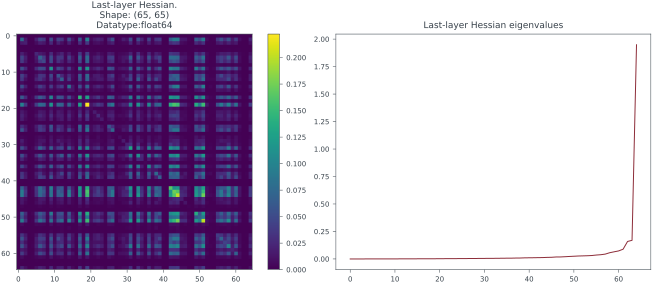

In [18]:
# compute last-layer Hessian
H_matrix = compute_hessian_lastlayer(MAP_PARAMS, bmnist)

# compute the Hessian eigendecomposition (ew=eigenwert, ev=eigenvector)
H_ews, H_evs = jnp.linalg.eigh(H_matrix)
Hi = H_evs @ jnp.diag(1 / H_evs) @ H_evs.T

# plot the Hessian and spectrum
plt.rcParams.update(bundles.beamer_moml(rel_height=1.5))
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))
im1 = ax1.imshow(H_matrix)
ax1.set_title(f"Last-layer Hessian.\nShape: {H_matrix.shape}\nDatatype:{H_matrix.dtype}")
#
ax2.plot(H_ews)
ax2.set_title(f"Last-layer Hessian eigenvalues")
#
fig.colorbar(im1, ax=ax1);

<hr style="margin: 50px">

# MAP Inference vs. LA-Predictive Inference

Recall the formula for the "vanilla" (MAP) DL confidence, $\sigma(|f(x', \theta_*)|)$, and the formula for the LA predictive confidence $\sigma(|z(x')|)$, where:

$$
\sigma(z(x')) = \sigma \Big( \frac{f(x', \theta_*)}{\sqrt{1 + \frac{\pi}{8}  J(x')^\top (-\Psi^{-1}) J(x')}} \Big)  \approx p(y = 1 | x', \mathcal{D})
$$

Below we provide an implementation of $\sigma(|f(x', \theta_*)|)$, and the task is to implement $\sigma(|z(x')|)$. This also requires to implement $J(x')$ using `jax`. Importantly:

* Make sure to use the Hessian eigendecomposition to save computation, do not directly invert the Hessian each time.
* Note that we are using the last-layer Hessian $\Psi$, so we just need to compute the last-layer Jacobians $J(x')$ accordingly.


<div style="border-radius: 10px; background-color: #ffe0e0; width: 85%;  text-align: left; margin: auto;">
  <div style="background: rgba(0, 0, 0, 0.05); border-style: solid; border-width: thin; border-radius: 10px; filter: brightness(0.9); padding: 10px; "><p style=""><b>Also important:</b></p>
  </div>
<div style="padding: 10px">
The loss we used to train is the <b>negative log-likelihood</b>, which we <b>minimized</b>. But our mathematical derivations seeked to maximize the log-likelihood instead. Both are equivalent, the only different is that <b>our computed <code>H_matrix</code> is already <code>-(psi)</code>, we don't need to multiply it by -1.
</div>    
</div>

In [24]:

def map_confidence(params, bmnist, batch_size=50):
    """
    This function computes and returns ``sigmoid(abs(model))`` over the
    whole test subset, i.e. the MAP confidence scores typically used in
    DL that exhibit pathological overconfidence.

    :param params: Parameters for the ``mlp`` model.
    :param bmnist: Dictionary as returned by ``MNIST.extract_bmnist``.
    :param batch_size: To prevent running out of memory or going too 
    slow, result is computed in batches of this size.
    :returns: One confidence scalar per entry in the test subset,
      corresponding to ``sigmoid(abs(mlp(x)))``.
    """
    result = []
    for x_batch, y_batch in test_dataloader(bmnist, batch_size):
        x_batch = x_batch.reshape(len(x_batch), -1)
        logits = mlp(params, x_batch)
        confidences = jax.nn.sigmoid(abs(logits))
        result.extend(confidences)
    #
    result = jnp.array(result)
    return result

@jax.jit
def compute_jacobian_lastlayer(params, inputs, enable_assertions=False):
    """
    This function computes the Jacobian of ``mlp`` with respect to
    the last-layer parameters, given the ``inputs``.
    
    :param params: See ``compute_hessian_lastlayer``.
    :param inputs: Batch of flattened input images with shape 
      ``(batch, in_shape)``.
    :returns: A Jacobian matrix of shape ``(batch, lastlayer_params)``,
      containing the partial derivatives of the ``mlp`` outputs with
      respect to the last-layer parameters.
    """
    def mlp_output_wrapper(new_last_layer_params, inputs):
        w = new_last_layer_params[:-1].reshape(new_last_layer_params[:-1].shape[0], 1)
        b = jnp.array([new_last_layer_params[-1]])
        new_params = params.copy()
        new_params[-1] =  (w,b)

        if enable_assertions:
            for idx, mp in enumerate(params):
                assert params[idx][0].shape == new_params[idx][0].shape , f"idx {idx} {repackaged_params[idx][0].shape} != {_repackaged_params[idx][0].shape}"
                assert params[idx][1].shape == new_params[idx][1].shape 

        return mlp(new_params, inputs)

    last_params = jnp.append(*params[-1])
    J_vec = jax.jacobian(mlp_output_wrapper)(last_params, inputs)
    return J_vec


def la_predictive_confidence(params, bmnist, h_ews, h_evs, 
                             prior_precision=1, batch_size=50, enable_assertions=False):
    """
    This function computes and returns ``sigmoid(abs(z(x)))`` over the
    whole test subset, i.e. the LA predictive confidence as derived
    above (note that our computed Hessian is already ``-psi``).
    
    :param params: see ``map_confidence``.
    :param bmnist: see ``map_confidence``.
    :param batch_size: see ``map_confidence``.
    :param h_ews: Vector of eigenvalues obtained via Hessian eigendecomposition.
    :param h_evs: Orthogonal square matrix of eigenvectors obtained via
      Hessian eigendecomposition, such that ``H = h_evs @ h_ews @ h_evs.T``
    :param prior_precision: Since we are inverting ``H``, and ``h_ews`` tend to
      be near-zero, we may run into numerical issues. This scalar is a constant
      being added to all eigenvalues, preventing this issue and also becoming
      a regularization hyperparameter.
    :returns: One confidence scalar per entry in the test subset, correspoding
      to the LA predictive confidence ``sigmoid(abs(z(x)))``.
    """
    neg_psi_inv = h_evs @ jnp.diag(1 / (h_ews + prior_precision)) @ h_evs.T
    
    if enable_assertions:
        assert neg_psi_inv.shape == (len(h_ews), len(h_ews))
        assert neg_psi_inv.shape == (65, 65)
    result = []

    for x_batch, y_batch in test_dataloader(bmnist, batch_size):
        x_batch = x_batch.reshape(len(x_batch), -1)
        logits = mlp(params, x_batch) 
        j_vec = compute_jacobian_lastlayer(params, x_batch) 
        if enable_assertions:
            assert j_vec.shape == (len(x_batch), 65), f"j_vec.shape {j_vec.shape}"
        results = j_vec @ neg_psi_inv @ j_vec.T
        diagonal_entries = jnp.diag(results)

        if enable_assertions:
            for idx in range(len(diagonal_entries)):
                assert jnp.isclose(diagonal_entries[idx] , j_vec[idx, :] @ neg_psi_inv @ j_vec[idx, :].T) , f"idx {idx} {diagonal_entries[idx]} != {j_vec[idx, :] @ neg_psi_inv @ j_vec[idx, :].T}"

        confidences  = jax.nn.sigmoid(abs(logits / (1 + jnp.pi/8 * diagonal_entries)))
        if enable_assertions:
            assert jnp.allclose(results, results.T), "Results, not symmetric."
            assert confidences.shape == (len(x_batch),), f"confidences.shape {confidences.shape}"  
        result.extend(confidences)  
    result = jnp.array(result)
    return result

<br style="margin: 10px">
<div style="border-radius: 10px; background-color: ##e4fae4; width: 75%;  text-align: center; margin: auto;">
  <div style="background: rgba(0, 0, 0, 0.05); border-style: solid; border-width: thin; border-radius: 10px; filter: brightness(0.9); padding: 10px; "><p style=""><b>Expected result:</b></p>
  </div>
<div style="padding: 10px">
<b>Running the cell below should gather the MAP confidence results for the test subset of binary MNIST, as well as the LA-predictive confidences using different prior precisions. The subsequent plot should show how there are very few low-confidence MAP entries, and the majority are near 1 (in our case this doesn't show overconfidence itself, since MNIST is a rather easy problem and we are only sampling in-distribution data). In contrast, all LA-predictive confidences are strictly lower than MAP, and the plotted curve should also get lower as the precision decreases.</b>
</div>    
</div>
<br style="margin: 20px">

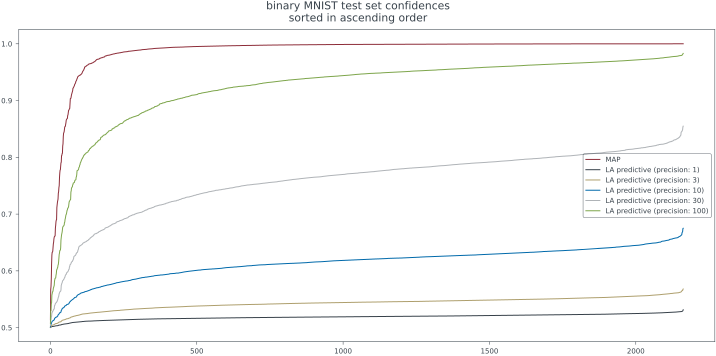

In [25]:
# compute MAP and LA predictive confidences over the test set for different precision hyperpars
PRIOR_PRECISIONS = [1, 3, 10, 30, 100]
MAP_CONFS = map_confidence(MAP_PARAMS, bmnist)
LAP_CONFS = {pp: la_predictive_confidence(MAP_PARAMS, bmnist, H_ews, H_evs, prior_precision=pp)
             for pp in PRIOR_PRECISIONS}

# plot 
plt.rcParams.update(bundles.beamer_moml(rel_height=2))
fig, ax = plt.subplots(figsize=(10, 5))
#
ax.plot(sorted(MAP_CONFS), label="MAP")
for pp, confs in LAP_CONFS.items():
    ax.plot(sorted(confs), label=f"LA predictive (precision: {pp})")
ax.legend()
fig.suptitle("binary MNIST test set confidences\nsorted in ascending order");

<hr style="margin: 50px">

# Inspect Results


Once we successfully computed the MAP and LA-predictive confidences for the MNIST test set, we want to gather and plot the following data samples for either confidence metric:

  * The 5 “positive” examples with largest confidence (i.e. clear positives)
  * The 5 “negative” examples with smallest confidence (i.e. clear negatives)
  * The 5 “positive” examples with smallest confidence (i.e. confusing positives)
  * The 5 “negative” examples with largest confidence (i.e. confusing negatives)
  
The cell below provides the `retrieve_interesting_samples` function, which does all of the heavy-lifting. No modification should be required.

In [26]:
def retrieve_interesting_samples(confidences, targets, num_samples=5):
    """
    :param confidences: Numpy array of floats determining how confident
      is a given classification.
    :param targets: Numpy array of ground truth scalars ``y_i`` given in
      same order as confidences.
    :returns: A dictionary ``{"posmax": [idx1, idx2, ...], "posmin": [...],
      "negmax": [...], "negmin": [...]}`` with the indexes for the N
      labeled "positive" examples with largest confidence, the N "positive"
      examples with smallest confidence, the N "negative" examples with
      largest confidence and the N "negative" examples with smallest
      confidence, where N is ``num_samples``.
    """
    pos_idxs = (targets == 1).nonzero()[0]
    neg_idxs = (targets == 0).nonzero()[0]
    #
    assert num_samples >= 1, "Number of samples must be positive!"
    assert len(pos_idxs) >= num_samples, "Less positive predictions than num_samples!"
    assert len(neg_idxs) >= num_samples, "Less negative predictions than num_samples!"
    #    
    posmax_idxs = np.argpartition(confidences[pos_idxs], -num_samples)[-num_samples:]
    posmin_idxs = np.argpartition(confidences[pos_idxs], num_samples)[:num_samples]
    negmax_idxs = np.argpartition(confidences[neg_idxs], -num_samples)[-num_samples:]
    negmin_idxs = np.argpartition(confidences[neg_idxs], num_samples)[:num_samples]
    #
    result = {"posmax": pos_idxs[posmax_idxs],
              "posmin": pos_idxs[posmin_idxs],
              "negmax": neg_idxs[negmax_idxs],
              "negmin": neg_idxs[negmin_idxs]}
    return result


# Also gather the targets using functionality from last week
targets = test_predictions(get_params(opt_state), bmnist, 
                           BATCH_SIZE, CLASSIFICATION_THRESHOLD)[2]

<br style="margin: 10px">
<div style="border-radius: 10px; background-color: ##e4fae4; width: 85%;  text-align: center; margin: auto;">
  <div style="background: rgba(0, 0, 0, 0.05); border-style: solid; border-width: thin; border-radius: 10px; filter: brightness(0.9); padding: 10px; "><p style=""><b>Expected result:</b></p>
  </div>
<div style="padding: 10px">
<b>Running the cells below should gather indexes for the 4 interesting groups of test samples, as described above. Then, each group should be plotted in its own row, where each row contains all samples of the same class. The "clear" rows should depict instances that are clearly identifiable, whereas the "confusing" rows should depict examples that present some irregularities. Despite the slight differences between MAP and LA-predictive, we note that binary-MNIST is considered a very easy problem, and the benefit of LA may be better leveraged on harder ones and/or when inspecting out-of-distribution data, not covered in this tutorial.</b>
</div>    
</div>
<br style="margin: 20px">

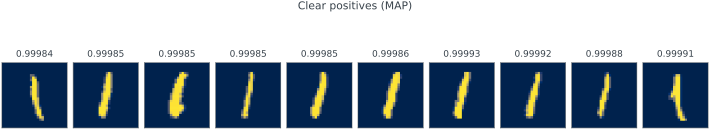

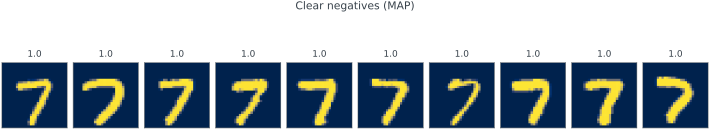

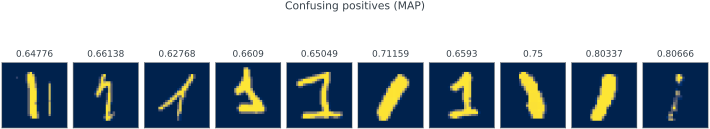

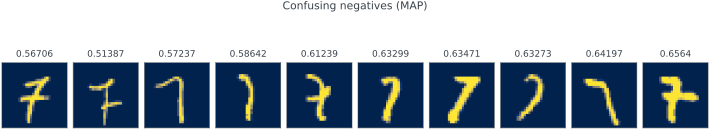

In [27]:
confidences = np.array(MAP_CONFS)
metric = "MAP"
NUM_SAMPLES = 10
ROUNDING_DECIMALS = 5
# gather interesting samples
interesting = retrieve_interesting_samples(confidences, np.array(targets), NUM_SAMPLES)

# Plot "clear" examples
inspect_batch(bmnist["x_test"][interesting["posmax"]], 
              confidences[interesting["posmax"]].round(decimals=ROUNDING_DECIMALS),
              title=f"Clear positives ({metric})")

inspect_batch(bmnist["x_test"][interesting["negmax"]],
              confidences[interesting["negmax"]].round(decimals=ROUNDING_DECIMALS),
              title=f"Clear negatives ({metric})")

# Plot "confusing" examples
inspect_batch(bmnist["x_test"][interesting["posmin"]], 
              confidences[interesting["posmin"]].round(decimals=ROUNDING_DECIMALS),
              title=f"Confusing positives ({metric})")

inspect_batch(bmnist["x_test"][interesting["negmin"]], 
              confidences[interesting["negmin"]].round(decimals=ROUNDING_DECIMALS),
              title=f"Confusing negatives ({metric})");

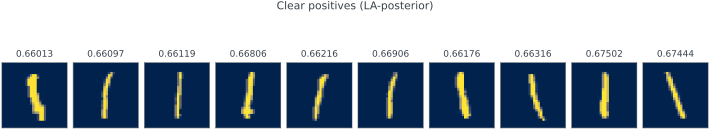

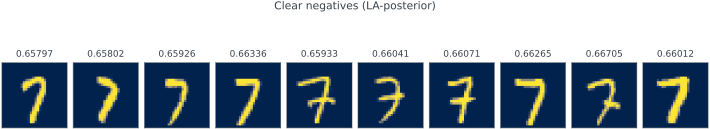

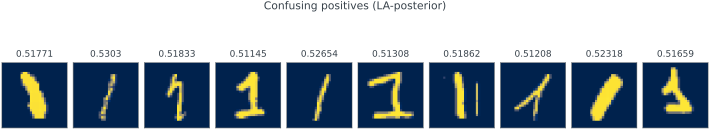

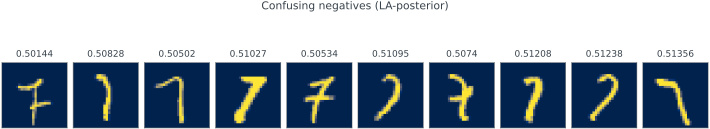

In [28]:
confidences = np.array(LAP_CONFS[10])
metric = "LA-posterior"
NUM_SAMPLES = 10
ROUNDING_DECIMALS = 5
# gather interesting samples
interesting = retrieve_interesting_samples(confidences, np.array(targets), NUM_SAMPLES)

# Plot "clear" examples
inspect_batch(bmnist["x_test"][interesting["posmax"]], 
              confidences[interesting["posmax"]].round(decimals=ROUNDING_DECIMALS),
              title=f"Clear positives ({metric})")

inspect_batch(bmnist["x_test"][interesting["negmax"]],
              confidences[interesting["negmax"]].round(decimals=ROUNDING_DECIMALS),
              title=f"Clear negatives ({metric})")

# Plot "confusing" examples
inspect_batch(bmnist["x_test"][interesting["posmin"]], 
              confidences[interesting["posmin"]].round(decimals=ROUNDING_DECIMALS),
              title=f"Confusing positives ({metric})")

inspect_batch(bmnist["x_test"][interesting["negmin"]], 
              confidences[interesting["negmin"]].round(decimals=ROUNDING_DECIMALS),
              title=f"Confusing negatives ({metric})");


End of `Exercise Sheet No. 10 — Overcoming DL Overconfidence via Laplace Approximations`.